In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

In [2]:
import xarray as xr
import geopandas as gp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from dask.distributed import Client
import cartopy.crs as ccrs

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 12,Total memory: 48.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38371,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 48.00 GiB
Comm: tcp://127.0.0.1:39361,Total threads: 3
Dashboard: /proxy/40031/status,Memory: 12.00 GiB
Nanny: tcp://127.0.0.1:37689,


# Loading crabeater data
We will only deal with `HUMAN_OBSERVATION` data, this means that humans directly observed the animals in the field. Data collected through satellite tags is excluded.

In [78]:
crabeaters = pd.read_csv('../Cleaned_Data/All_sources_clean_data.csv')
crabeaters = crabeaters[crabeaters.basis_record == "HUMAN_OBSERVATION"]
crabeaters

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010
...,...,...,...,...,...,...,...,...,...,...
154792,2006-02-19T13:00:00Z,-67.0779,69.9942,1,HUMAN_OBSERVATION,2006,2,summer,moulting,2000
154793,2006-01-30T13:00:00Z,-67.9639,40.7485,1,HUMAN_OBSERVATION,2006,1,summer,moulting,2000
154794,2006-02-19T13:00:00Z,-67.0892,69.9950,2,HUMAN_OBSERVATION,2006,2,summer,moulting,2000
154795,2006-02-19T13:00:00Z,-67.1395,69.9984,1,HUMAN_OBSERVATION,2006,2,summer,moulting,2000


In [80]:
crab_obs_shp = gp.GeoDataFrame(crabeaters, geometry = gp.points_from_xy(crabeaters.longitude, crabeaters.latitude), crs = 'EPSG:4326')
crab_obs_shp

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,geometry
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-62.86430 -64.90280)
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.14430 -65.14130)
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.05950 -65.14020)
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-63.98020 -65.09770)
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.13000 -65.33830)
...,...,...,...,...,...,...,...,...,...,...,...
154792,2006-02-19T13:00:00Z,-67.0779,69.9942,1,HUMAN_OBSERVATION,2006,2,summer,moulting,2000,POINT (69.99420 -67.07790)
154793,2006-01-30T13:00:00Z,-67.9639,40.7485,1,HUMAN_OBSERVATION,2006,1,summer,moulting,2000,POINT (40.74850 -67.96390)
154794,2006-02-19T13:00:00Z,-67.0892,69.9950,2,HUMAN_OBSERVATION,2006,2,summer,moulting,2000,POINT (69.99500 -67.08920)
154795,2006-02-19T13:00:00Z,-67.1395,69.9984,1,HUMAN_OBSERVATION,2006,2,summer,moulting,2000,POINT (69.99840 -67.13950)


<AxesSubplot:>

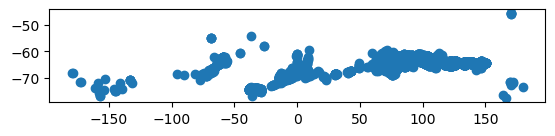

In [6]:
crab_obs_shp.plot()

In [129]:
measo = gp.read_file(r'/g/data/v45/la6889/GIS_DataBase/Shapefiles/MEASO/measo_wgs84.shp')
#Removing MEASO areas for temperate regions
measo = measo[measo.zone != "Temperate"]
#Removing duplicate WPA polygons
measo = measo[(measo.fill != "#016074FF") | (measo.name != "WPA")].reset_index(drop = True)
#Checking results
measo

,name,sector,zone,fill,LongName,geometry
0,WPA,West Pacific,Antarctic,#BCECFEFF,West Pacific Antarctic,"POLYGON ((-180.00000 -64.70000, -166.00000 -64..."
1,WPS,West Pacific,Subantarctic,#1094AFFF,West Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -128.00000 -65..."
2,WPN,West Pacific,Northern,#054e70FF,West Pacific Northern,"POLYGON ((-125.00000 -40.00000, -125.00000 -56..."
3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,"POLYGON ((-125.00000 -85.00000, -125.00000 -65..."
4,EPS,East Pacific,Subantarctic,#5F9EA0FF,East Pacific Subantarctic,"POLYGON ((-125.00000 -65.20000, -125.00000 -56..."
5,EPN,East Pacific,Northern,#4B7D7EFF,East Pacific Northern,"POLYGON ((-125.00000 -56.80000, -125.00000 -40..."
6,AOA,Atlantic,Antarctic,#BCECFEFF,Atlantic Antarctic,"POLYGON ((-59.00000 -59.40791, -59.00000 -58.6..."
7,AOS,Atlantic,Subantarctic,#1094AFFF,Atlantic Subantarctic,"POLYGON ((30.00000 -56.50000, 28.00000 -56.500..."
8,AON,Atlantic,Northern,#054e70FF,Atlantic Northern,"POLYGON ((30.00000 -41.70000, 30.00000 -47.900..."
9,CIA,Central Indian,Antarctic,#FFFFFFFF,Central Indian Antarctic,"POLYGON ((30.00000 -85.00000, 30.00000 -56.500..."


<GeoAxesSubplot:>

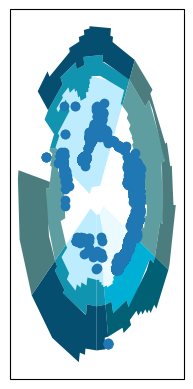

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
measo.plot(ax = ax, color = measo['fill'], transform = ccrs.PlateCarree())
crab_obs_shp.plot(ax = ax, transform = ccrs.PlateCarree())

In [131]:
new_crab = []
for s in measo.sector.unique():
    sector = measo[measo.sector == s]
    pts = gp.sjoin(crab_obs_shp, sector)
    new_crab.append(pts)

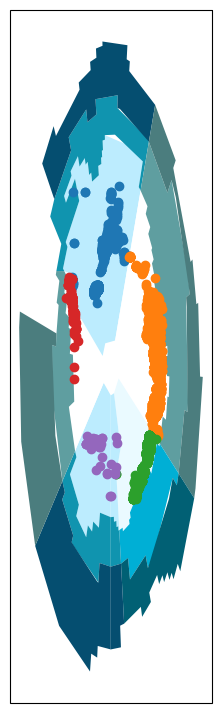

In [132]:
new_crab = gp.pd.concat(new_crab).sort_index()
fig = plt.figure(figsize = (3, 9))
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
measo.plot(ax = ax, color = measo['fill'], transform = ccrs.PlateCarree())
for k, g in new_crab.groupby('sector'):
    g.plot(ax = ax, label = k, transform = ccrs.PlateCarree())

In [134]:
print(len(new_crab) - len(crab_obs_shp))

-9


<GeoAxesSubplot:>

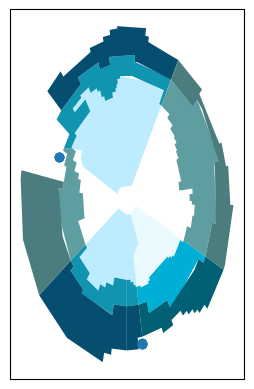

In [136]:
outer = new_crab.merge(crab_obs_shp, how = 'outer', indicator = True)
fig = plt.figure()
ax = fig.add_subplot(111, projection = ccrs.SouthPolarStereo())
measo.plot(ax = ax, color = measo['fill'], transform = ccrs.PlateCarree())
outer[outer._merge == 'right_only'].plot(ax = ax, transform = ccrs.PlateCarree())

In [142]:
ras = rasterio.open('/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/Rasters_tiff/coastline_contour.tif')

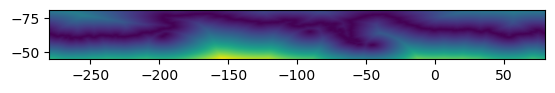

<AxesSubplot:>

In [143]:
from rasterio.plot import show
rasterio.plot.show(ras)

In [145]:
coord_list = [(x, y) for x, y in zip(new_crab.geometry.x, new_crab.geometry.y)]

In [148]:
new_crab['dist_coast'] = [x for x in ras.sample(coord_list)]
new_crab.head()

,event_date,latitude,longitude,number_individuals,basis_record,year,month,season_year,life_stage,decade,geometry,index_right,name,sector,zone,fill,LongName,dist_coast
0,2019-03-09T00:00:00Z,-64.9028,-62.8643,1,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-62.86430 -64.90280),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,[74.64624527731887]
1,2019-03-13T00:00:00Z,-65.1413,-64.1443,10,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.14430 -65.14130),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,[113.03095113855144]
2,2019-03-15T00:00:00Z,-65.1402,-64.0595,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.05950 -65.14020),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,[109.02526895890156]
3,2019-03-15T00:00:00Z,-65.0977,-63.9802,6,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-63.98020 -65.09770),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,[106.89908908315738]
4,2019-03-14T00:00:00Z,-65.3383,-64.1300,65,HUMAN_OBSERVATION,2019,3,autumn,in-between,2010,POINT (-64.13000 -65.33830),3,EPA,East Pacific,Antarctic,#FFFFFFFF,East Pacific Antarctic,[107.83525836256132]


In [168]:
new_crab.dist_coast.iloc[0].flatten()

array([74.64624528])